In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

from collections import defaultdict
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image

In [2]:
torch.manual_seed(2004)
random.seed(2004)
np.random.seed(2004)

In [3]:
BATCH_SIZE = 16 # Assumed
LR = 0.025 # Same as paper
MOMENTUM = 0.9 # Same as paper
USE_NESTEROV = True # Same as paper
EPOCHS = 25
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PRINT_INTERVAL = 1000

MODEL_SAVE_DIR = "models"

In [4]:

transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=0), # Padding not mentioned in paper
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

if not os.path.exists("embeddings/active_learning_embeddings.pkl"):
    raise ValueError("Please run eval_sim_clr.py first to generate embeddings for active learning")
with open("embeddings/active_learning_embeddings.pkl", "rb") as f:
    active_learning_embeddings = pickle.load(f)

print("Embeddings shape:", len(active_learning_embeddings))

all_images = []
all_labels = []
for key, value_dict in active_learning_embeddings.items():
    image = value_dict["image"]
    print(image.flatten().min(), image.flatten().max())
    image = Image.fromarray(image.astype("uint8")) # Convert to PIL image
    label = np.array(value_dict["label"]) # Convert scalar to 1D array
    print(np.array(image).shape, label.shape)
    all_images.append(image)
    all_labels.append(label)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label)
        return image, label
    
# train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
# train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

train_set = CustomDataset(images=all_images, labels=all_labels, transform=transform)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Embeddings shape: 496
4 235
(32, 32, 3) ()
0 220
(32, 32, 3) ()
0 248
(32, 32, 3) ()
20 246
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 253
(32, 32, 3) ()
3 213
(32, 32, 3) ()
1 255
(32, 32, 3) ()
0 225
(32, 32, 3) ()
0 255
(32, 32, 3) ()
1 247
(32, 32, 3) ()
2 241
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
19 255
(32, 32, 3) ()
0 252
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
1 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
4 255
(32, 32, 3) ()
4 220
(32, 32, 3) ()
0 253
(32, 32, 3) ()
11 255
(32, 32, 3) ()
3 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
5 227
(32, 32, 3) ()
4 232
(32, 32, 3) ()
18 255
(32, 32, 3) ()
0 252
(32, 32, 3) ()
3 255
(32, 32, 3) ()
0 251
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 252
(32, 32, 3) ()
0 243
(32, 32, 3) ()
9 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
3 255
(32, 32, 3) ()
2 245
(32, 32, 3) ()
0 246
(32, 32, 3) ()
6 245
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 255
(32, 32, 3) ()
0 255
(3

In [5]:
print(len(train_dl))
print(len(test_dl))

31
625


In [6]:
data = train_dl.__iter__().__next__()
images, labels = data
print(images.shape, labels.shape)

torch.Size([16, 3, 32, 32]) torch.Size([16])


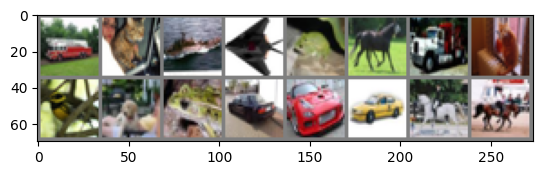

truck cat   ship  plane frog  horse truck cat   bird  dog   frog  car   car   car   horse horse


In [7]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

data_iter = iter(train_dl)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(BATCH_SIZE)))

In [8]:
def create_resnet18_model():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(512, 10) # Adapt final layer to CIFAR-10 classes
    return model

In [9]:
model = create_resnet18_model()
model = model.to(DEVICE)

In [10]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, nesterov=USE_NESTEROV)
scheduler = CosineAnnealingLR(optimiser, T_max=EPOCHS) # T_max is the number of epochs

In [11]:
print(len(train_dl), len(test_dl))

31 625


In [12]:
num_train_batches = len(train_dl)

In [13]:
def calculate_metrics(true_positive, false_positive, false_negative, total):
    precision = {}
    recall = {}
    f1_score = {}
    accuracy = {}
        
    for class_name in classes:
        tp = true_positive[class_name]
        fp = false_positive[class_name]
        fn = false_negative[class_name]
        total_count = total[class_name]

        # Accuracy (same as existing code)
        accuracy[class_name] = 100 * float(tp) / total_count if total_count != 0 else 0

        # Precision = TP / (TP + FP)
        precision[class_name] = tp / (tp + fp) if (tp + fp) != 0 else 0

        # Recall = TP / (TP + FN)
        recall[class_name] = tp / (tp + fn) if (tp + fn) != 0 else 0

        # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
        if (precision[class_name] + recall[class_name]) > 0:
            f1_score[class_name] = 2 * (precision[class_name] * recall[class_name]) / (precision[class_name] + recall[class_name])
        else:
            f1_score[class_name] = 0

    return precision, recall, f1_score, accuracy

In [14]:
for epoch in range(EPOCHS):
    total = {class_name: 0 for class_name in classes}
    true_positive = defaultdict(int)
    false_positive = defaultdict(int)
    false_negative = defaultdict(int)

    running_loss = 0.0
    total_examples = 0

    for i, data in enumerate(train_dl):
        inputs, labels = data
        optimiser.zero_grad()

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        output = model(inputs)

        # Count true positives, false positives, and false negatives
        _, predicted = torch.max(output, 1)
        
        for label, prediction in zip(labels, predicted):
            total[classes[label]] += 1 # Track total for accuracy

            if label == prediction:
                true_positive[classes[label]] += 1
            else:
                false_positive[classes[prediction]] += 1 # Predicted class is wrong
                false_negative[classes[label]] += 1 # Actual class is wrong
        
        loss = criterion(output, labels)

        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total_examples += len(labels)

        if (i % PRINT_INTERVAL == (PRINT_INTERVAL - 1)) or (i == num_train_batches - 1):
            current_lr = optimiser.param_groups[0]["lr"]
            print(f"Epoch: {epoch + 1} |  Batch: {i + 1}/{num_train_batches} | Loss: {running_loss / total_examples} | LR: {current_lr}")

    # Calculate metrics after each epoch
    precision, recall, f1_score, accuracy = calculate_metrics(
                                                            true_positive=true_positive, 
                                                            false_positive=false_positive, 
                                                            false_negative=false_negative, 
                                                            total=total
                                                            )
    # Print metrics for each class:
    print(f"Epoch: {epoch + 1}")
    for class_name in classes:
        print(f"Class: {class_name} | Precision: {precision[class_name]:.2f} | Recall: {recall[class_name]:.2f} | F1 Score: {f1_score[class_name]:.2f} | Accuracy: {accuracy[class_name]:.2f}")
    print("\n")

    # Update scheduler after each epoch
    scheduler.step()

Epoch: 1 |  Batch: 31/31 | Loss: 0.309884813043379 | LR: 0.025
Epoch: 1
Class: plane | Precision: 0.16 | Recall: 0.09 | F1 Score: 0.11 | Accuracy: 8.57
Class: car | Precision: 0.14 | Recall: 0.18 | F1 Score: 0.16 | Accuracy: 17.81
Class: bird | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: cat | Precision: 0.14 | Recall: 0.15 | F1 Score: 0.14 | Accuracy: 14.63
Class: deer | Precision: 0.04 | Recall: 0.04 | F1 Score: 0.04 | Accuracy: 3.85
Class: dog | Precision: 0.24 | Recall: 0.22 | F1 Score: 0.23 | Accuracy: 21.82
Class: frog | Precision: 0.08 | Recall: 0.10 | F1 Score: 0.09 | Accuracy: 10.00
Class: horse | Precision: 0.19 | Recall: 0.23 | F1 Score: 0.21 | Accuracy: 22.50
Class: ship | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: truck | Precision: 0.21 | Recall: 0.22 | F1 Score: 0.21 | Accuracy: 21.69


Epoch: 2 |  Batch: 31/31 | Loss: 0.3583791380928409 | LR: 0.024901433766430975
Epoch: 2
Class: plane | Precision: 0.08 | Recall: 0

In [15]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
model_path = f"{MODEL_SAVE_DIR}/fully_supervised_model.pth"
torch.save(model.state_dict(), model_path)

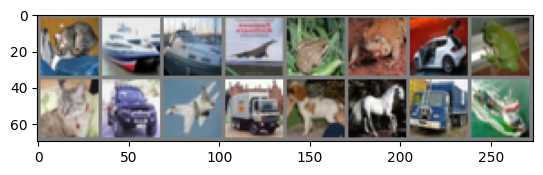

Ground truth: cat  , ship , ship , plane, frog , frog , car  , frog , cat  , car  , plane, truck, dog  , horse, truck, ship 


In [16]:
data_iter = iter(test_dl)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images))
print(f"Ground truth: {', '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE))}")

In [17]:
saved_model = create_resnet18_model()
saved_model.load_state_dict(torch.load(model_path))
saved_model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
output = saved_model(images.to(DEVICE))
_, predicted = torch.max(output, 1)

In [19]:
print(f"Predictions: {', '.join(f'{classes[predicted[j]]:5s}' for j in range(BATCH_SIZE))}")

Predictions: car  , truck, truck, truck, horse, frog , frog , car  , horse, plane, dog  , truck, cat  , dog  , horse, horse


In [20]:
total = {class_name: 0 for class_name in classes}
true_positive = defaultdict(int)
false_positive = defaultdict(int)
false_negative = defaultdict(int)

saved_model.eval()

with torch.no_grad():
    for data in test_dl:
        images, labels = data

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        output = saved_model(images)

        _, predicted = torch.max(output, 1)
        
        for label, prediction in zip(labels, predicted):
            total[classes[label]] += 1 # Track total for accuracy

            if label == prediction:
                true_positive[classes[label]] += 1
            else:
                false_positive[classes[prediction]] += 1 # Predicted class is wrong
                false_negative[classes[label]] += 1 # Actual class is wrong

In [21]:
precision, recall, f1_score, accuracy = calculate_metrics(
                                                        true_positive=true_positive, 
                                                        false_positive=false_positive, 
                                                        false_negative=false_negative, 
                                                        total=total
                                                        )

In [22]:
for class_name in total.keys():
    print(f"Class name: {class_name}")
    print(f"Accuracy: {accuracy[class_name]:.4f}")
    print(f"Precision: {precision[class_name]:.4f}")
    print(f"Recall: {recall[class_name]:.4f}")
    print(f"F1 Score: {f1_score[class_name]:.4f}")
    print("\n")

Class name: plane
Accuracy: 0.8000
Precision: 0.1111
Recall: 0.0080
F1 Score: 0.0149


Class name: car
Accuracy: 22.7000
Precision: 0.1130
Recall: 0.2270
F1 Score: 0.1509


Class name: bird
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Class name: cat
Accuracy: 4.0000
Precision: 0.2299
Recall: 0.0400
F1 Score: 0.0681


Class name: deer
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Class name: dog
Accuracy: 27.7000
Precision: 0.2904
Recall: 0.2770
F1 Score: 0.2835


Class name: frog
Accuracy: 8.7000
Precision: 0.1812
Recall: 0.0870
F1 Score: 0.1176


Class name: horse
Accuracy: 35.4000
Precision: 0.1139
Recall: 0.3540
F1 Score: 0.1723


Class name: ship
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Class name: truck
Accuracy: 63.3000
Precision: 0.1976
Recall: 0.6330
F1 Score: 0.3012


